In [1]:
import torch
import matplotlib.pyplot as plt
import librosa
import json
from torch import nn
import numpy as np
import d2l.torch as d2l
from torch.utils.data import DataLoader,TensorDataset
import math
import random


In [2]:
DATA_DIR = './genres'
JSON_PATH = 'data.json'
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.9
TRAIN_OVDER_ALL = 0.7
BATCH_SIZE = 32
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # seconds
SAMPLE_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
def load_data(json_path):
    with open(json_path,'r') as f:
        data = json.load(f,encoding='gb18030')
    X, y = np.array(data['mfcc']), np.array(data['labels'])
    return X, y

In [4]:
X, y = load_data(JSON_PATH) 
X = X.astype(np.float32)
X, y = torch.from_numpy(X), torch.from_numpy(y)
data_loader = TensorDataset(X,y)

In [5]:
def split_train_test(data_loader,ratio=0.7):
    cnt = dict()
    for X,y in data_loader:
        if y.item() in cnt.keys():
            cnt[y.item()]+=ratio
        else:
            cnt[y.item()]=ratio
            
    train_dataloader = []
    test_dataloader = []
    index = [i for i in range(len(data_loader))]
    random.shuffle(index)
    for i in range(len(index)):
        X,y = data_loader[index[i]]
        cnt[y.item()]-=1
        if cnt[y.item()]>=0:
            train_dataloader.append((X,y))
        else :
            test_dataloader.append((X,y))
    return train_dataloader, test_dataloader

In [6]:
train_dataloader, test_dataloader = split_train_test(data_loader,TRAIN_OVDER_ALL)
train_dataloader = DataLoader(train_dataloader,batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataloader,batch_size=BATCH_SIZE)

In [7]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, device, epochs):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 0.1],legend=['train loss', 'test loss'])
    n_batches = len(train_dataloader)
    for epoch in range(epochs):
        model.train()
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            predict = model(X)
            optimizer.zero_grad()
            loss = loss_fn(predict,y.long()).mean()
            loss.backward()
            optimizer.step()
            if (i + 1) % (n_batches // 5) == 0 or i == n_batches - 1:
                animator.add(epoch + (i + 1) / n_batches,
                             (loss.item()/len(y), None))
        model.eval()
        metric = d2l.Accumulator(2)
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                predict = model(X)
                metric.add(loss_fn(predict,y.long()).sum(),len(X))
            animator.add(epoch + 1, (None, metric[0]/metric[1]))

In [8]:
class myloss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,y_hat,y,r=2):
        y2d = torch.stack((r*torch.cos(y*math.pi/5),r*torch.sin(y*math.pi/5)),dim=1)
        return ((y_hat - y2d)**2)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(13,65,batch_first=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.gru(x)[0] + x.repeat(1,1,5)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x) + x
        x = self.pool(x)
        x = self.conv3(x) + x
        x = self.pool(x)
        x = self.conv4(x) + x.repeat(1,2,1,1)
        x = self.pool(x)
        x = self.conv5(x) + x
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [10]:
model = torch.load('model_0.999_0.911.pt')
# model = Model()

In [11]:
model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
model.to(device)
params_1x = [param for name,param in model.named_parameters() if name[:3]!='cla']
optimizer = torch.optim.SGD([
    {'params':params_1x},{'params':model.classifier.parameters(),'lr':LEARNING_RATE*100}
],lr=LEARNING_RATE,weight_decay=0.01)
loss_fn = myloss()

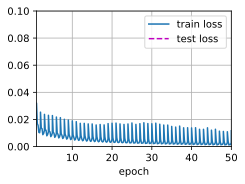

In [12]:
train(model,train_dataloader,test_dataloader,optimizer, loss_fn, device, 50)

In [13]:
def draw(model,dataloader):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        X = model(X)
        x1 = X[:,0].cpu().detach().numpy()
        x2 = X[:,1].cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        plt.scatter(x1,x2,c=y)
    plt.show()

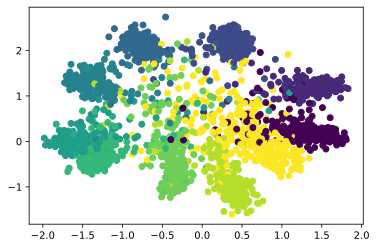

In [14]:
draw(model,test_dataloader)

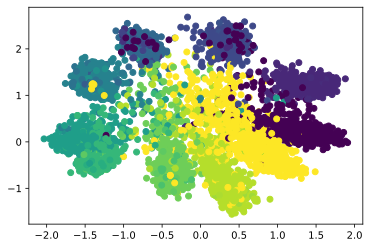

In [15]:
draw(model,train_dataloader)